## Tic-Tac-Toe Agent
​
In this notebook, you will learn to build an RL agent (using Q-learning) that learns to play Numerical Tic-Tac-Toe with odd numbers. The environment is playing randomly with the agent, i.e. its strategy is to put an even number randomly in an empty cell. The following is the layout of the notebook:
        - Defining epsilon-greedy strategy
        - Tracking state-action pairs for convergence
        - Define hyperparameters for the Q-learning algorithm
        - Generating episode and applying Q-update equation
        - Checking convergence in Q-values

#### Importing libraries
Write the code to import Tic-Tac-Toe class from the environment file

In [241]:
from TicTacToe_Env import TicTacToe
import collections
import numpy as np
import random
import pickle
import time
from matplotlib import pyplot as plt

#### Instantiation and initialization

In [242]:
# Create an instance of class to be used by functions here to access class functions
env = TicTacToe()

In [243]:
# Initialise Q_dictionary as 'Q_dict'
# Using defaultdict to initialize to avoid keyerror
Q_dict = collections.defaultdict(dict)

#### Functions

In [244]:
# Function to convert state array into a string to store it as keys in the dictionary
# states in Q-dictionary will be of form: x-4-5-3-8-x-x-x-x
def Q_state(state):
    return ('-'.join(str(e) for e in state)).replace('nan','x')

In [245]:
# Function to return valid (all possible) actions corresponding to a state
# Important to avoid errors during deployment.
def valid_actions(state):
    valid_Actions = [i for i in env.action_space(state)[0]]
    return valid_Actions

In [246]:
# Function to add new Q-values to the Q-dictionary
def add_to_dict(state):
    # Get all valid actions for the state
    valid_act = valid_actions(state)
    # Convert state to Q state format
    state_q = Q_state(state)
    
    if state_q not in Q_dict.keys():
        for action in valid_act:
            Q_dict[state_q][action]=0

In [247]:
# Q dict Example 
Q_dict_example={'x-x-x-x-x-x-x-x-x':{(7,5):0.0, (5,5):1.0}}
max_value_action = max(Q_dict_example['x-x-x-x-x-x-x-x-x'], key=Q_dict_example['x-x-x-x-x-x-x-x-x'].get)
print('Max q value is',Q_dict_example['x-x-x-x-x-x-x-x-x'][max_value_action],'and action is', max_value_action)

Max q value is 1.0 and action is (5, 5)


#### Epsilon-decay function

In [248]:
# Total episodes
total_episodes = 5000000
exp_factor = 0.0000008

In [249]:
# Defining epsilon decay function
def epsilon_decay(num_episodes):
    max_epsilon = 1.0
    min_epsilon = 0.001
    epsilon = []
    for i in range(0,num_episodes):
        epsilon.append(min_epsilon + (max_epsilon - min_epsilon) * np.exp(-exp_factor*i))
    return epsilon

# Call function to make a list of epsilon decay
lst_epsilon_decay = epsilon_decay(total_episodes)
#Check first few values in list 
lst_epsilon_decay[:3]

[1.0, 0.9999992008003198, 0.9999984016012787]

#### Epsilon-greedy strategy

This is strategy for choosing action

In [250]:
# Defining epsilon-greedy policy. You can choose any function epsilon-decay strategy
def epsilon_greedy(state, episode_number):
    # Get epsilon from the list of decaying epsilons based on index
    epsilon = lst_epsilon_decay[episode_number]
    # Random number z between 0.0 and 1.0
    z = np.random.random()
    
    if z > epsilon:
        #Exploitation: choosing action with max q-value from current state
        state_q = Q_state(state) # Convert state to Q state format
        return max(Q_dict[state_q],key=Q_dict[state_q].get)
    else:
        #Exploration: randomly choosing action
        return random.choice(valid_actions(state))

#### Tracking the state-action pairs for checking convergence

In [251]:
# Initialise States_tracked as 'States_track' (for convergence)
# Using defaultdict to initialize to avoid keyerror
States_track = collections.defaultdict(dict)

In [252]:
# Define 4 sample state actions to track Q value convergence
sample_state_actions = [('x-x-x-x-x-x-x-x-x',(1,1)),
                        ('x-x-x-x-x-x-x-x-x',(0,3)),
                        ('x-1-2-x-x-x-x-x-x',(5,5)),
                        ('x-x-x-7-x-x-x-x-8',(0,9))]

# Initialise states to be tracked
def initialise_tracking_states():
    # Add samples to States_track dictionary
    for s_a in sample_state_actions:
        States_track[s_a[0]][s_a[1]] = []  
        
        
# Call function to initialize tracking states
initialise_tracking_states()

#Check States_track dictionary
States_track

defaultdict(dict,
            {'x-x-x-x-x-x-x-x-x': {(1, 1): [], (0, 3): []},
             'x-1-2-x-x-x-x-x-x': {(5, 5): []},
             'x-x-x-7-x-x-x-x-8': {(0, 9): []}})

In [253]:
# Save states to be tracked
def save_tracking_states():
    for state in States_track.keys():
        for action in States_track[state].keys():
            if state in Q_dict and action in Q_dict[state]:
                States_track[state][action].append(Q_dict[state][action])

In [254]:
# Defining a function to save the Q-dictionary as a pickle file
def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

#### Define hyperparameters

In [255]:
# Hyperparameters
learning_rate = 0.1      # Learning rate
gamma = 0.8              # discount factor

### Q-update loop
This is the learning algorithm to update Q values. At the end of loop we should have converged Q-values.<br/>
Epsilon greedy algo will then use these converged Q values to determine actions based on strategy defined in that function.

In [256]:
start_time = time.time()

for episode in range(total_episodes):
    # Create an instance of class for every episode so that constructor runs and resets state with every episode
    episode_env = TicTacToe()
    state = episode_env.reset() # Get environment state
    is_terminal = False
    
    while not is_terminal:
        # Add current state to Q_dict
        add_to_dict(state)
    
        # Choose action based on epsilon greedy approach
        action = epsilon_greedy(state, episode)
        
        # Convert state to Q state format
        state_q = Q_state(state)
        
        # Take the action and observe the new state and reward
        reward, new_state, is_terminal = episode_env.step(state, action)
        
        # Convert state to Q state format
        new_state_q = Q_state(new_state)
        
        #print('old state:',state_q)
        #print('new state:',new_state_q)
        
        # Update Q values
        if is_terminal:
            #print('TERMINATED')
            Q_dict[state_q][action] += learning_rate * (reward - Q_dict[state_q][action])
        else:
            # Add new state to Q_dict so that max works
            add_to_dict(new_state)
            Q_dict[state_q][action] += learning_rate * (reward + gamma * Q_dict[new_state_q][max(Q_dict[new_state_q],key=Q_dict[new_state_q].get)] - Q_dict[state_q][action])
            # Update state to new state for next step in while loop
            state=new_state
           
    # Update the states that we are tracking after every few episodes
    if ((episode+1) % 5000) == 0:
        save_tracking_states()
        
elapsed_time = time.time() - start_time
print(elapsed_time)
save_obj(States_track,'States_tracked')   
save_obj(Q_dict,'Policy')

3997.931097984314


#### Check the Q-dictionary

In [257]:
len(Q_dict)

1409148

In [258]:
Q_dict

defaultdict(dict,
            {'x-x-x-x-x-x-x-x-x': {(0, 1): 3.1289859685272714,
              (0, 3): 2.2576775554214827,
              (0, 5): 2.412407459775147,
              (0, 7): 2.2578758579521043,
              (0, 9): 1.6970891503088203,
              (1, 1): 2.6329205580471045,
              (1, 3): 2.180931370208764,
              (1, 5): 2.5008171730933513,
              (1, 7): 1.1936270484856422,
              (1, 9): 3.734125788043509,
              (2, 1): 3.4321046890899995,
              (2, 3): 2.096797772431017,
              (2, 5): 2.5828341348891373,
              (2, 7): 1.7165847327602175,
              (2, 9): 2.3342176224701827,
              (3, 1): 1.8066632691201603,
              (3, 3): 1.6447556606431615,
              (3, 5): 1.580290736766914,
              (3, 7): 1.8623200058240261,
              (3, 9): 2.5460536091161847,
              (4, 1): 2.457670811543581,
              (4, 3): 1.190479974065566,
              (4, 5): 1.1159728654514638,
  

In [261]:
# try checking for one of the states - that which action your agent thinks is the best  -----This will not be evaluated

#Best action for state
test_state = '5-x-x-x-8-x-x-x-x'
print('Best action for state', test_state, 'is', max(Q_dict[test_state],key=Q_dict[test_state].get))

Best action for state 5-x-x-x-8-x-x-x-x is (1, 9)


#### Check the states tracked for Q-values convergence
(non-evaluative)

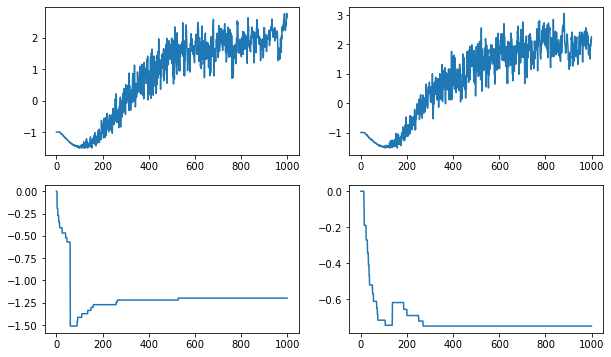

In [260]:
# Write the code for plotting the graphs for state-action pairs tracked
plt.figure(0, figsize=(10,6))
for i,sa_pair in enumerate(sample_state_actions):
    x = np.asarray(range(0, len(States_track[sa_pair[0]][sa_pair[1]])))
    y = np.asarray(States_track[sa_pair[0]][sa_pair[1]])
    plt.subplot(2,2,i+1)
    plt.plot(x,y)
    plt.show

### Epsilon - decay check

In [262]:
max_epsilon = 1.0
min_epsilon = 0.001
time = np.arange(0,5000000)
epsilon = []
for i in range(0,len(time)):
    epsilon.append(min_epsilon + (max_epsilon - min_epsilon) * np.exp(-0.0000008*i))

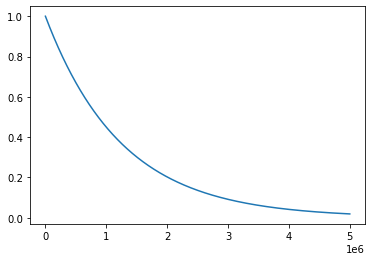

In [263]:
plt.plot(time, epsilon)
plt.show()